In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pytorch_metric_learning import losses

In [4]:
from models import densenet161, mobilenet_v2, make_model, vgg16
from dataset import make_dataloaders, get_crop_to_opposite_original_df
from train import do_train
from infer_utils import (
    predict_opposite_crop_to_crop,
    predict_original_to_crop,
    predict_opposite_original_to_crop,
    plot_match_pairs,
)
from utils import compute_accuracy, plot_train_results, make_dir

In [5]:
ds_path = '/home/korakova/kaggle/'

Попробуем дообучить модели, которые отобрали на шаге 1 с помощью ArcFaceLoss

### Train vgg16 with ArcFaceLoss

In [7]:
num_epochs = 20
num_workers = 10
batch_size = 20
lr = 1e-4
train_last_layers = False
pretrained = True
step_size = 200
gamma = 0.8

model_type = vgg16
model_name = "vgg16"
task_type = "classification"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
exp_name = (
    f"{task_type}_{model_name}_1024_ArcFace_{lr}_ss_{step_size}_ll_{train_last_layers}"
)
weight_directory = os.path.join("results", exp_name)
make_dir(weight_directory)
dataloaders, num_classes = make_dataloaders(task_type, batch_size, num_workers)

In [8]:
model, params_to_update = make_model(
    train_last_layers, pretrained, device, model_type
)
criterion = losses.ArcFaceLoss(num_classes, 1024)
optimizer = optim.Adam(params_to_update, lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
train_result = do_train(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs, weight_directory)

100%|██████████| 20/20 [01:39<00:00,  4.95s/it, epoch=19, loss=tensor(0.2111), lr=0.0001]


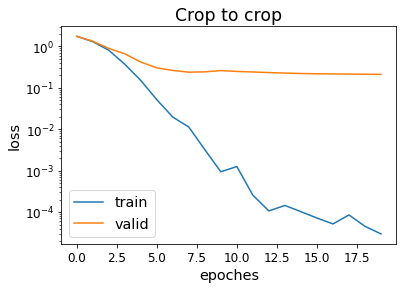

In [11]:
plot_train_results(train_result, "Crop to crop", yscale=True)

### Compute quality on validation set

In [12]:
target_df = get_crop_to_opposite_original_df()

#### 1. Crop to opposite crop match

In [13]:
model_weight = "best_model.pt"
features = "local"
weights = f"results/{exp_name}/{model_weight}"

batch_size = 1
model_type = vgg16
task_type = "crop_crop"

dataloaders = make_dataloaders(task_type, batch_size)
model, _ = make_model(False, False, "cpu", model_type, weights)

pred_crop_crop = predict_opposite_crop_to_crop(
    model, features, dataloaders["test"], target_df
)

100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


In [14]:
accuracy = compute_accuracy(pred_crop_crop, "path_crop_opposite", "path_crop_opposite_gt")
print(f'Accuracy for crop to crop match {accuracy}')

Accuracy for crop to crop match 0.9


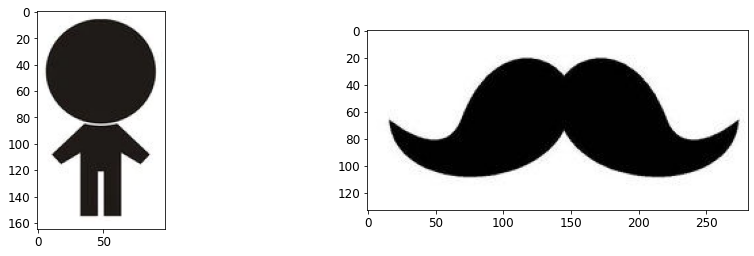

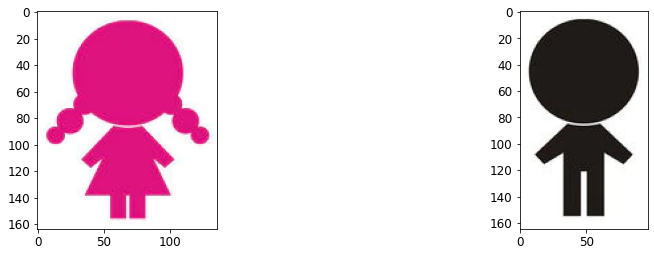

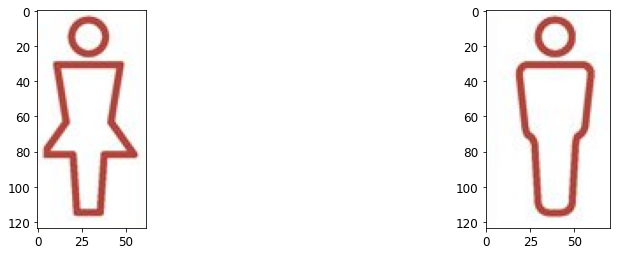

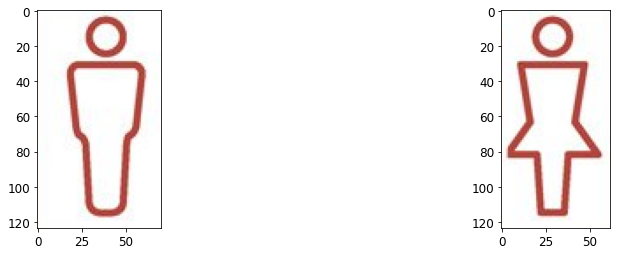

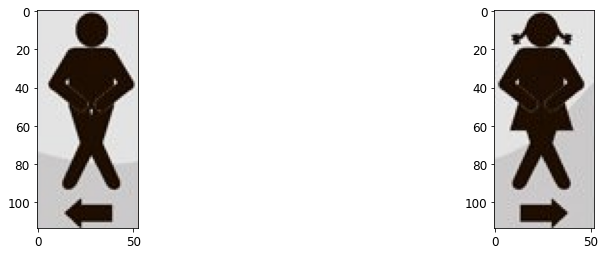

In [15]:
plot_match_pairs(pred_crop_crop, 5, 'path_crop_opposite')

#### 2. Crop to original same gender

In [17]:
model_weight = "best_model.pt"
features = "local"
weights = f"results/{exp_name}/{model_weight}"

batch_size = 1
model_type = vgg16
task_type = "crop_orig"

model, _ = make_model(False, False, "cpu", model_type, weights)
dataloaders = make_dataloaders(task_type, batch_size, num_workers)

pred_crop_orig = predict_original_to_crop(
    model, features, dataloaders["test"], target_df
)

100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


In [18]:
accuracy = compute_accuracy(pred_crop_orig, "path_orig", "path_orig_gt")
print(f'Accuracy for crop to original match {accuracy}')

Accuracy for crop to original match 0.8


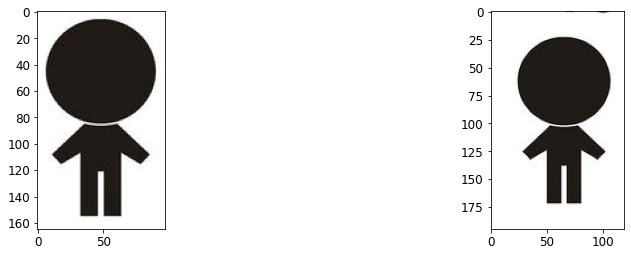

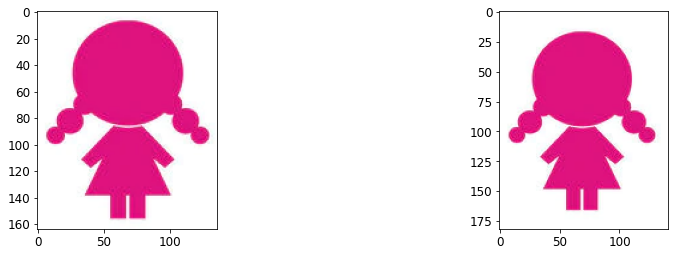

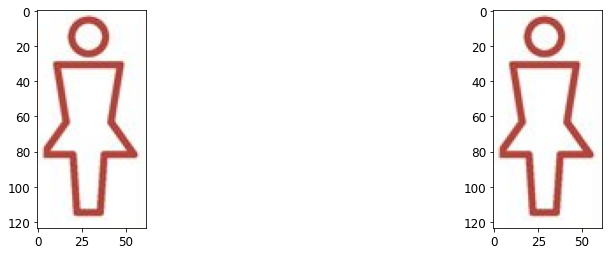

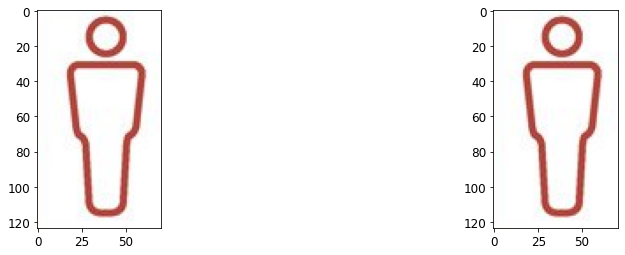

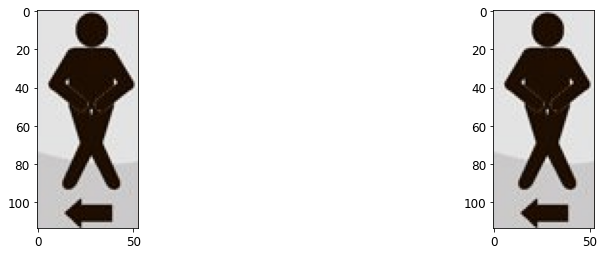

In [19]:
plot_match_pairs(pred_crop_orig, 5, 'path_orig')

#### 3. Crop to original opposite match

In [20]:
df_result = predict_opposite_original_to_crop(pred_crop_crop, pred_crop_orig, target_df)

In [21]:
accuracy = compute_accuracy(df_result, "path_orig", "path_orig_opposite")
print(f'Accuracy for crop to original opposite match {accuracy}')

Accuracy for crop to original opposite match 0.7


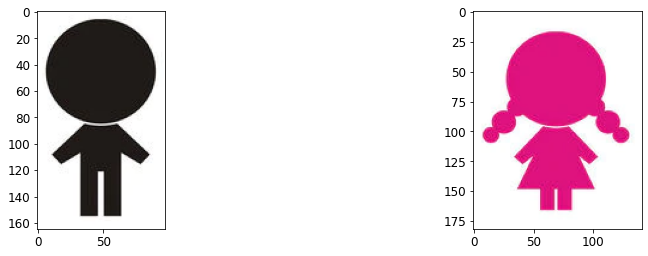

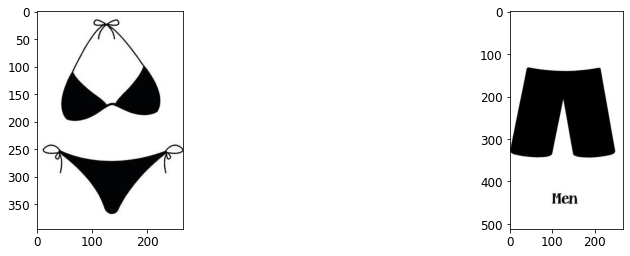

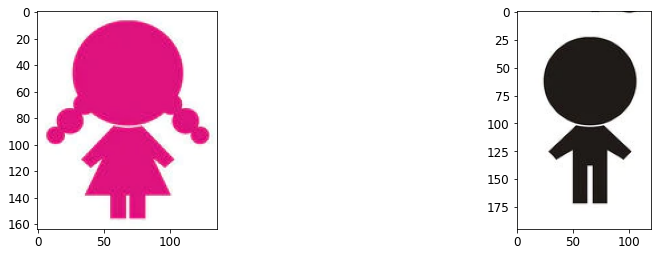

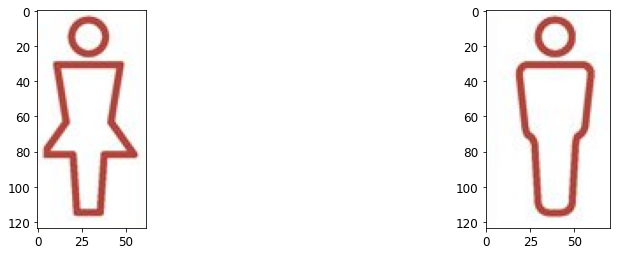

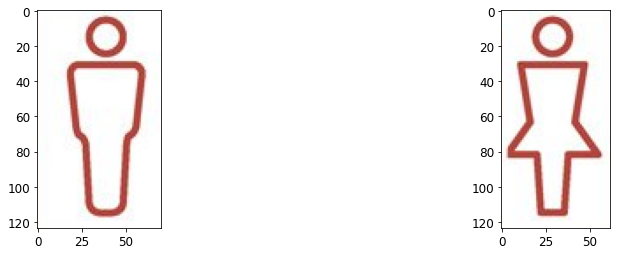

In [22]:
plot_match_pairs(df_result, 5, 'path_orig_opposite')